In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt
import scipy.signal
import multiprocessing

In [2]:
# Function that load the real data
def load_real_data(epoch, f=None):
    fval = []
    for i in range(1,N+1):
        d = "epoch%02d/rep%02d/"%(epoch, i)
        fval.append(np.load(d+"fval.npy"))
        print("Loaded fval from %sfval.npy"%d)
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), (np.concatenate(fval)-0.799)*100/(1.4-0.799), np.concatenate(frms)


def rand_func(f,n=600,i=1):
    x = np.linspace(-10,100, 10000)
    pdf = f(x,i)
    pdf /= np.sum(pdf)
    cdf = np.cumsum(pdf)
    u = np.random.random(n)
    return np.array([x[np.argmax(uu<=cdf)] for uu in u])
    

# Function for "loading" random data
def load_data(epoch, f=np.sin):
    fval = []
    for i in range(1,N+1):
        d = "epoch%02d/rep%02d/"%(epoch, i)
        fval.append(rand_func(f,i=epoch))
        print("Faked fval for %sfval.npy"%d)
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)


In [3]:
# Choose which data to load
#load_data = load_real_data
# Arbitrary propability distribution
def func(x,i):
    return np.exp(-0.5*((x-15*(i-1))/(10/i))**2)

def func2(x,i):
    return np.exp(-0.5*((x-10*(i**2-1))/(10))**2)

def U(x):
    """ The potential, in kbT
    """
    return np.sin(x/10)

epochs = 3
N=16
maxval=100
minval=0
fval = []
reps = []
frms = []
for i in range(1,epochs+1):
    r,f,fr = load_data(i,func2)
    reps.append(r)
    fval.append(f)
    frms.append(fr)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)
frms = np.concatenate(frms)

Faked fval for epoch01/rep01/fval.npy
Faked fval for epoch01/rep02/fval.npy
Faked fval for epoch01/rep03/fval.npy
Faked fval for epoch01/rep04/fval.npy
Faked fval for epoch01/rep05/fval.npy
Faked fval for epoch01/rep06/fval.npy
Faked fval for epoch01/rep07/fval.npy
Faked fval for epoch01/rep08/fval.npy
Faked fval for epoch01/rep09/fval.npy
Faked fval for epoch01/rep10/fval.npy
Faked fval for epoch01/rep11/fval.npy
Faked fval for epoch01/rep12/fval.npy
Faked fval for epoch01/rep13/fval.npy
Faked fval for epoch01/rep14/fval.npy
Faked fval for epoch01/rep15/fval.npy
Faked fval for epoch01/rep16/fval.npy
Faked fval for epoch02/rep01/fval.npy
Faked fval for epoch02/rep02/fval.npy
Faked fval for epoch02/rep03/fval.npy
Faked fval for epoch02/rep04/fval.npy
Faked fval for epoch02/rep05/fval.npy
Faked fval for epoch02/rep06/fval.npy
Faked fval for epoch02/rep07/fval.npy
Faked fval for epoch02/rep08/fval.npy
Faked fval for epoch02/rep09/fval.npy
Faked fval for epoch02/rep10/fval.npy
Faked fval f

28800
99.97799779977998 0 24857 124 0.9997799779977998


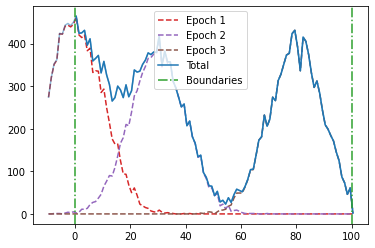

In [4]:
_largest_val,_lowest_val=0,0
def make_hist(fval):
    global _largest_val,_lowest_val
    print(len(fval))
    _largest_val = np.max(fval)
    _lowest_val  = np.min(fval)
    _binmax = min(_largest_val, maxval)
    _binmin = max(_lowest_val,  minval)
    _maxbins = np.sum((fval>minval)*(fval<maxval))//200
    _binsize = (_binmax-_binmin)/min(_maxbins,100)
    print(_binmax,_binmin, np.sum((fval>minval)*(fval<maxval)),_maxbins,_binsize)
    bin_edges = np.arange(_lowest_val,_largest_val+_binsize , _binsize)
    hist, bin_edges = np.histogram(fval, bins=bin_edges)
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    # higher edge larger than minval AND lower edge lower than maxval
    mask = (bin_edges[1:]>minval)*(bin_edges[:-1]<maxval)

    for i in range(1,epochs+1):
        _ep_hist, _ = np.histogram(fval[epcs==i], bins=bin_edges)
        plt.plot(bin_centers, _ep_hist, "--", color="C%d"%(i+2), label="Epoch %d"%i)


    plt.plot(bin_centers, hist, color="C0", alpha=0.5)
    plt.plot(bin_centers[mask], hist[mask], color="C0", label="Total")
    plt.axvline(minval, linestyle="-.", color="C2", label="Boundaries")
    plt.axvline(maxval, linestyle="-.", color="C2")
    plt.legend()
    plt.show()
    return hist, bin_edges, bin_centers, mask

hist, bin_edges, bin_centers, mask = make_hist(fval)

[16 54] {'prominences': array([ 89.55555556, 353.22222222]), 'left_bases': array([0, 0]), 'right_bases': array([29, 80]), 'widths': array([12.34976526, 28.35890336]), 'width_heights': array([-330.66666667, -215.16666667]), 'left_ips': array([ 9.83333333, 40.30696203]), 'right_ips': array([22.18309859, 68.66586538])}
[29 80] {'prominences': array([ 89.55555556, 292.44444444]), 'left_bases': array([16, 54]), 'right_bases': array([54, 96]), 'widths': array([11.94733619, 19.02349885]), 'width_heights': array([330.66666667, 245.55555556]), 'left_ips': array([22.18309859, 70.07865169]), 'right_ips': array([34.13043478, 89.10215054])}
[64, 110] [6.66514806 7.33485194]
[110, 64] [7.33485194 6.66514806]
16 (array([ 64, 110]), array([7, 9]))


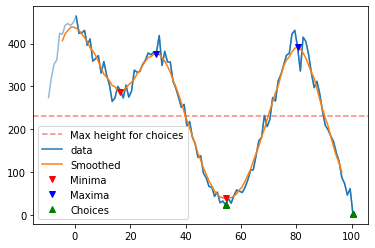

[64, 110, 110, 110, 110, 110, 110, 110, 110, 64, 64, 64, 64, 64, 64, 110]

In [5]:
from math import floor, ceil

def rolling_mean(data, window=10, center = True, fill=np.nan):
    if(center):
        start_offset = floor(window/2)
        end_offset   = -ceil(window/2)+1
        if(end_offset==0): end_offset=None
    else:
        start_offset = window-1
        end_offset   = None

    window-=1
    if(window==0): window=None

    cumsum = np.nancumsum(data, axis=0, dtype=float)
    mean   = np.full_like(cumsum, fill)
    mean[start_offset:end_offset] = (cumsum[window:]-cumsum[:-window])/window

    return mean

def choose_bins(hist,mask,bin_centers):
    _smoothed = rolling_mean(-hist)
    _nanmask = np.isfinite(_smoothed)*mask
    _peaks,_que = scipy.signal.find_peaks(_smoothed[_nanmask], width=5, distance=10)
    _peaks2,_que2 = scipy.signal.find_peaks(-_smoothed[_nanmask], width=5, distance=10)
    print(_peaks, _que)
    print(_peaks2, _que2)


    _maxh = np.max(hist[mask])
    _minh = np.min(hist[mask])
    # If not ends have sampled been, make sure min height set to zero is
    if(_largest_val<maxval or _lowest_val>minval):
        _minh=0

    _crith = (_maxh-_minh)/2+_minh

    choices = []
    # convert from masked indices to unmasked
    _indexes = np.arange(len(hist))[_nanmask]
    for p in _peaks:
        if(hist[_nanmask][p]<_crith):
            choices.append(_indexes[p])

    _zero_mask = mask*(hist!=0)
    _indexes = np.arange(len(hist))[_zero_mask]

    # TODO: refactor below
    #Handle not peaks-edge case
    if(len(choices)==0):
        if(hist[mask][-1]<_crith):
            choices.append(_indexes[-1])
        if(hist[mask][0]<_crith):
            choices.append(_indexes[0])
    else:
        # Check if first/last extrema is a maxima -> also include the far end(s)
        if(_peaks2.size>0 and _peaks[-1]<_peaks2[-1] and hist[mask][-1]<_crith):
            choices.append(_indexes[-1])
        if(_peaks2.size>0 and _peaks[0]>_peaks2[0] and hist[mask][0]<_crith):
            choices.append(_indexes[0])

    _weights = [(_crith-hist[c]) for c in choices]
    _weights /= np.sum(_weights)
    print(choices,(_weights*(N-len(choices))))
    _srt_ind = np.argsort(-_weights)
    print([choices[i] for i in _srt_ind],(_weights[_srt_ind]*(N-len(choices))))

    # Each point has been added once
    _len_choice = len(choices)
    # Add more depending on weight. Multiplication is floored, so between 0 and _len_choice-1 too few are added
    for i in _srt_ind:
        for j in range(floor(_weights[i]*(N-_len_choice))):
            choices.append(choices[i])

    # Fill the rest in sorted order
    for i in range(N-len(choices)):
        choices.append(choices[_srt_ind[i]])


    print(len(choices), np.unique(choices, return_counts=True))

    plt.axhline(_crith, linestyle="--", c="r", alpha=0.5, label="Max height for choices")
    plt.plot(bin_centers, hist, color="C0", alpha=0.5)
    plt.plot(bin_centers[mask], hist[mask], color="C0", label="data")
    plt.plot(bin_centers, -_smoothed, color="C1", label="Smoothed")
    plt.plot(bin_centers[_nanmask][_peaks], -_smoothed[_nanmask][_peaks], "rv", label="Minima")
    plt.plot(bin_centers[_nanmask][_peaks2], -_smoothed[_nanmask][_peaks2], "bv", label="Maxima")
    plt.plot(bin_centers[choices], hist[choices], "g^", label="Choices")
    
    x=np.linspace(0,100,1000)
    plt.plot(x,np-exp(-U(x)))
    
    plt.legend()    
    plt.show()
    return choices

choose_bins(hist,mask,bin_centers)

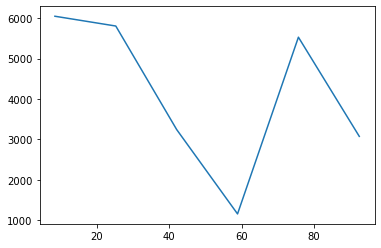

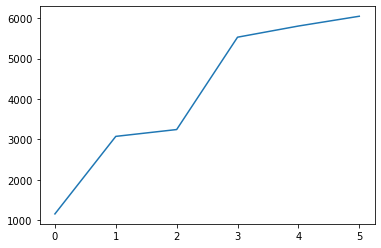

23 54.48580858085812 53.98591859185922 54.98569856985702
2 100.47568756875692 99.97579757975802 100.97557755775583
65 49.486908690869114 48.98701870187021 49.986798679868016


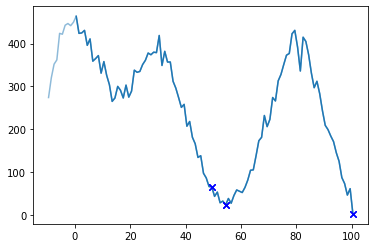

In [6]:
_big_bins = np.linspace(bin_edges[:-1][mask][0], bin_edges[1:][mask][-1], 7)

_big_hist, _ = np.histogram(fval, bins=_big_bins)
_big_bin_cnt = (_big_bins[1:]+_big_bins[:-1])/2

_srt_ndx = np.argsort(_big_hist)

plt.plot(_big_bin_cnt,_big_hist)
plt.show()

plt.plot(_big_hist[_srt_ndx])
plt.show()


_choices = []
_choose_bins=3
for i in range(_choose_bins):
    _binmask = mask*(bin_centers>_big_bins[_srt_ndx[i]])*(bin_centers<_big_bins[_srt_ndx[i]+1])*(hist!=0)
    _smallest_bin = np.argmin(hist[_binmask])
    _choices.append(np.arange(len(hist))[_binmask][_smallest_bin])
    print(hist[_choices[-1]], bin_centers[_choices[-1]], bin_edges[_choices[-1]], bin_edges[_choices[-1]+1])

for i in range(N-len(_choices)):
    _choices.append(_choices[i])

chosen_bins=_choices

plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0")
plt.plot(bin_centers[_choices], hist[_choices], "bx")
plt.show()

[14.60946095 18.15181518 85.14851485 ... 73.19031903 30.83608361
 13.78437844] [65.94059406  9.5929593   3.82838284 ... 47.23872387 32.54125413
 16.83168317]
(14400,) (14400,)


/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/paajasan/anaconda3/lib/python3.7/site-p

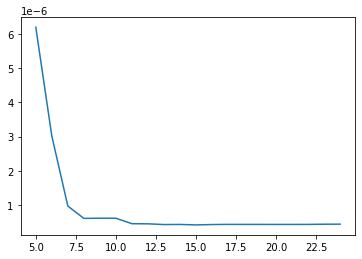

[ 1.74961191 16.53862287 28.91413679 55.07153881 80.32722335 99.12185058] [-1.46973911e-03  1.55499104e-04 -1.46110328e-04  8.63008884e-05
 -1.83807897e-04  1.83388652e-03]
[16.53862287 55.07153881 99.12185058] [1.55499104e-04 8.63008884e-05 1.83388652e-03]
15


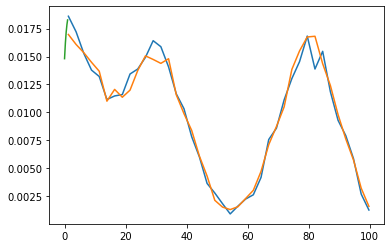

In [7]:
from sklearn.model_selection import train_test_split
_f_train, _f_test = train_test_split(fval, test_size=0.5)
print(_f_test, _f_train)
print(_f_test.shape, _f_train.shape)

_ttbins = np.linspace(bin_edges[:-1][mask][0],bin_edges[1:][mask][-1], 41)
_bincents = (_ttbins[:-1]+_ttbins[1:])/2

_train_hist, _ = np.histogram(_f_train, bins=_ttbins, density=True)
_test_hist,  _ = np.histogram(_f_test,  bins=_ttbins, density=True)

_degs = np.arange(5,25)
_pols = []
_chi2 = []

_x = np.linspace(bin_edges[:-1][mask][0],bin_edges[1:][mask][0],10000)

for d in _degs:
    _pol = np.poly1d(np.polyfit(_bincents, _train_hist, d))
    _pols.append(_pol)
    _dist = np.sum((_test_hist-_pol(_bincents))**2)/len(_bincents)
    _chi2.append(_dist)
    #plt.plot(_x, _pol(_x))

plt.plot(_degs, _chi2)
plt.show()


_pol_arg = np.argmin(_chi2)
dpol = _pols[_pol_arg].deriv()
ddpol = dpol.deriv()

# Find real unique roots
extr = dpol.roots
extr = np.unique(np.real(extr[np.isreal(extr)]))
print(extr, ddpol(extr))

# filter values outside our range
extr = extr[(_ttbins[0]<extr)*(extr<_ttbins[-1])]
# filter maxima and plateaus
extr = extr[ddpol(extr)>0]
print(extr, ddpol(extr))




print(_degs[_pol_arg])
    
plt.plot(_bincents, _train_hist)
plt.plot(_bincents, _test_hist)
plt.plot(_x, _pols[_pol_arg](_x))
plt.show()

[ 1.80005698 14.82446231 28.83169083 55.34075334 80.28400821] [-9.74981512  2.54587432 -2.04367277  2.6751892  -3.26546213]
[14.82446231 55.34075334] [2.54587432 2.6751892 ]
16


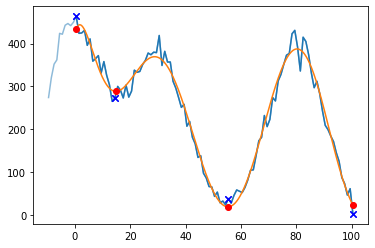

In [8]:
p = np.polyfit(bin_centers[mask], hist[mask], 10)
pol = np.poly1d(p)
dpol = pol.deriv()
ddpol = dpol.deriv()

_minbin = bin_centers[mask][0]
_maxbin = bin_centers[mask][-1]

# Find real unique roots
extr = dpol.roots
extr = np.unique(np.real(extr[np.isreal(extr)]))
print(extr, ddpol(extr))

# filter values outside our range
extr = extr[(_minbin<extr)*(extr<_maxbin)]
# filter maxima and plateaus
extr = extr[ddpol(extr)>0]
print(extr, ddpol(extr))

# ends
extr = list(extr)
if(dpol(_minbin)>0):
    extr.append(_minbin)
if(dpol(_maxbin)<0):
    extr.append(_maxbin)
    
extr = np.array(extr)


_choices = []
for e in extr:
    _choices.append(np.argmin(np.abs(bin_centers-e+np.where(hist==0, np.inf, 0))))

for i in range(N-len(_choices)):
    _choices.append(_choices[i])

print(len(_choices))
_choices=np.array(_choices)

_x = np.linspace(_minbin,_maxbin,10000)

plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0")
plt.plot(_x, pol(_x), color="C1")
plt.plot(extr, pol(extr), "ro")
plt.plot(bin_centers[_choices], hist[_choices], "bx")
plt.show()

In [12]:
def U(x):
    """ The potential, in kbT
    """
    return -2.5*np.sin(x/10)

def random_walk(start, nsteps=700, substeps=30, stepsize=0.1):
    pos = np.zeros(nsteps)
    x = start
    rng = np.random.default_rng()
    for i in range(nsteps):
        for j in range(substeps):
            x_trials = np.linspace(-10*stepsize, 10*stepsize,1000)
            p  = np.exp(-U(x+x_trials))*np.exp(-0.5*(x_trials/(stepsize))**2)
            ptot = np.sum(p)
            p /= ptot
            x += rng.choice(x_trials, p=p)
        
        pos[i]=x
        
    return pos

def choose_frames(chosen_bins):
    global bin_edges, fval, epcs, reps, frms
    _rng = np.random.default_rng()
    # lists for value, rpoch, rep and frame
    v,e,r,f=[],[],[],[]
    for bi in chosen_bins:
        vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
        ndx = _rng.choice(np.sum(vals_in_bin))
        
        v.append(fval[vals_in_bin][ndx])
        e.append(epcs[vals_in_bin][ndx])
        r.append(reps[vals_in_bin][ndx])
        f.append(frms[vals_in_bin][ndx])
    
    return np.array(v), np.array(e), np.array(r), np.array(f)

def simulate_epoch(epoch, chosen_bins):
    v,e,r,f = choose_frames(chosen_bins)

    with multiprocessing.Pool(min(multiprocessing.cpu_count(),N)) as p:
        fval = p.map(random_walk, v)
        
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)

def simulate_data(epoch, f=None):
    if(epoch==1):
        v = [0]*N
        
        with multiprocessing.Pool(min(multiprocessing.cpu_count(),N)) as p:
            fval = p.map(random_walk, v)
            
        reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
        frms = [np.arange(len(f)) for f in fval]

        return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)
    else:
        return simulate_epoch(epoch,chosen_bins)
        
    

11200
30.430430430430313 0 10712 53 0.5741590647251003


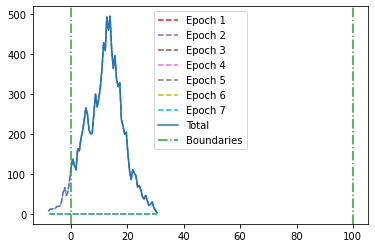

[] {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
[23] {'prominences': array([323.44444444]), 'left_bases': array([0]), 'right_bases': array([49]), 'widths': array([16.46816318]), 'width_heights': array([261.83333333]), 'left_ips': array([14.64159292]), 'right_ips': array([31.1097561])}
[67, 14] [9.13368984 4.86631016]
[67, 14] [9.13368984 4.86631016]
16 (array([14, 67]), array([ 5, 11]))


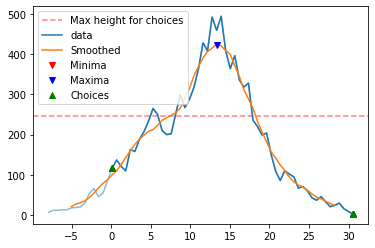

22400
37.013013013012866 0 21543 107 0.3701301301301287


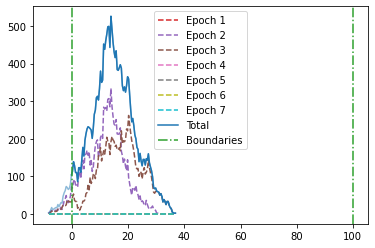

[] {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
[36] {'prominences': array([379.55555556]), 'left_bases': array([0]), 'right_bases': array([96]), 'widths': array([33.30107964]), 'width_heights': array([287.11111111]), 'left_ips': array([23.84076433]), 'right_ips': array([57.14184397])}
[122, 22] [8.7 5.3]
[122, 22] [8.7 5.3]
16 (array([ 22, 122]), array([ 6, 10]))


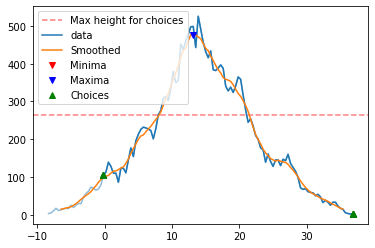

33600
89.00500500500449 0 32701 163 0.8900500500500449


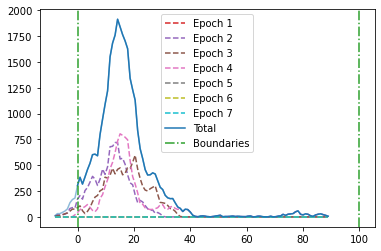

[74] {'prominences': array([29.55555556]), 'left_bases': array([17]), 'right_bases': array([88]), 'widths': array([34.20612245]), 'width_heights': array([-18.]), 'left_ips': array([48.1]), 'right_ips': array([82.30612245])}
[17 88] {'prominences': array([1419.66666667,   14.88888889]), 'left_bases': array([ 0, 74]), 'right_bases': array([74, 96]), 'widths': array([13.82755669,  8.0952381 ]), 'width_heights': array([978.61111111,  25.33333333]), 'left_ips': array([ 9.75558419, 83.57142857]), 'right_ips': array([23.58314088, 91.66666667])}
[83, 109, 9] [4.85120094 4.82581527 3.32298379]
[83, 109, 9] [4.85120094 4.82581527 3.32298379]
16 (array([  9,  83, 109]), array([4, 6, 6]))


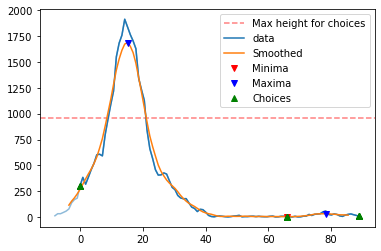

44800
94.16816816816753 0 43857 219 0.9416816816816752


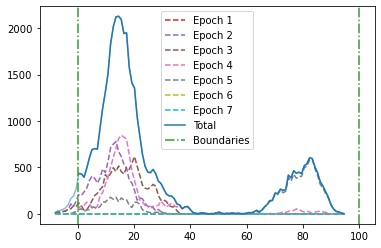

[58] {'prominences': array([500.88888889]), 'left_bases': array([15]), 'right_bases': array([85]), 'widths': array([43.05835674]), 'width_heights': array([-255.66666667]), 'left_ips': array([32.8787062]), 'right_ips': array([75.93706294])}
[15 85] {'prominences': array([1565.44444444,  401.66666667]), 'left_bases': array([ 0, 58]), 'right_bases': array([58, 96]), 'widths': array([13.26458024, 14.68143621]), 'width_heights': array([1125.72222222,  305.27777778]), 'left_ips': array([ 8.50921332, 77.3668942 ]), 'right_ips': array([21.77379357, 92.0483304 ])}
[67, 109, 9] [4.99235947 5.03019829 2.97744224]
[109, 67, 9] [5.03019829 4.99235947 2.97744224]
16 (array([  9,  67, 109]), array([3, 6, 7]))


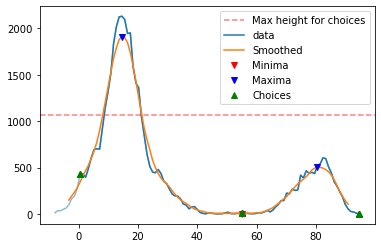

56000
99.47347347347275 0 54949 274 0.9947347347347275


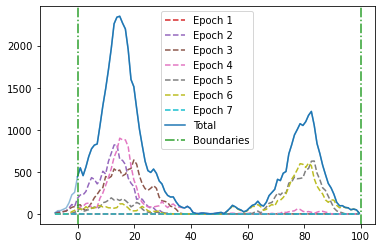

[46] {'prominences': array([1042.55555556]), 'left_bases': array([15]), 'right_bases': array([81]), 'widths': array([46.28848445]), 'width_heights': array([-527.94444444]), 'left_ips': array([26.62483039]), 'right_ips': array([72.91331484])}
[15 81] {'prominences': array([1697.11111111,  977.55555556]), 'left_bases': array([ 0, 46]), 'right_bases': array([46, 96]), 'widths': array([13.01752952, 14.37336443]), 'width_heights': array([1223.11111111,  560.44444444]), 'left_ips': array([ 8.25285171, 73.30748663]), 'right_ips': array([21.27038123, 87.68085106])}
[54, 108, 8] [4.95470099 4.9419912  3.10330781]
[54, 108, 8] [4.95470099 4.9419912  3.10330781]
16 (array([  8,  54, 108]), array([4, 6, 6]))


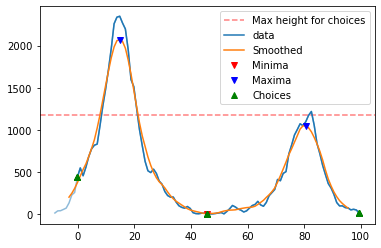

67200
100 0 65669 328 1.0


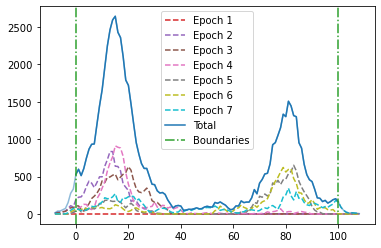

[45 58] {'prominences': array([1194.        ,   13.22222222]), 'left_bases': array([15, 53]), 'right_bases': array([80, 80]), 'widths': array([47.00824224,  6.38868708]), 'width_heights': array([-664.11111111, -114.27777778]), 'left_ips': array([26.17522321, 54.9893617 ]), 'right_ips': array([73.18346546, 61.37804878])}
[15 80] {'prominences': array([1862.        , 1145.77777778]), 'left_bases': array([ 0, 45]), 'right_bases': array([ 45, 100]), 'widths': array([13.36684886, 14.16677779]), 'width_heights': array([1355.44444444,  688.22222222]), 'left_ips': array([ 8.12886297, 73.42921857]), 'right_ips': array([21.49571184, 87.59599636])}
[53, 66, 108, 8] [3.37029703 3.34389439 3.12739274 2.15841584]
[53, 66, 108, 8] [3.37029703 3.34389439 3.12739274 2.15841584]
16 (array([  8,  53,  66, 108]), array([3, 5, 4, 4]))


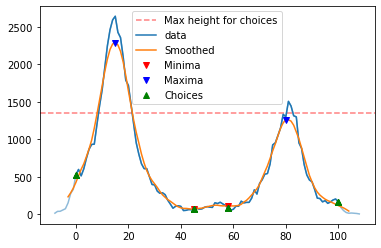

78400
100 0 76745 383 1.0


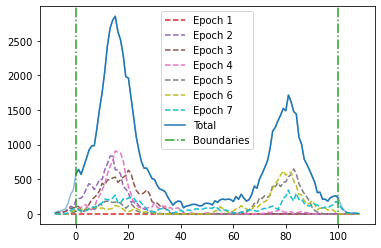

[45] {'prominences': array([1353.22222222]), 'left_bases': array([15]), 'right_bases': array([80]), 'widths': array([46.63017034]), 'width_heights': array([-799.94444444]), 'left_ips': array([25.91012658]), 'right_ips': array([72.54029692])}
[15 80] {'prominences': array([2012.44444444, 1321.33333333]), 'left_bases': array([ 0, 45]), 'right_bases': array([ 45, 100]), 'widths': array([13.50160145, 15.03146079]), 'width_heights': array([1464.55555556,  815.88888889]), 'left_ips': array([ 8.27132196, 72.69247084]), 'right_ips': array([21.77292341, 87.72393162])}
[53, 108, 8] [4.99307958 4.64821223 3.35870819]
[53, 108, 8] [4.99307958 4.64821223 3.35870819]
16 (array([  8,  53, 108]), array([4, 6, 6]))


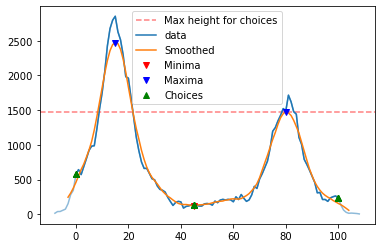

In [13]:
epochs = 7
N=16
maxval=100
minval=0
fval = []
reps = []
frms = []
epcs = []
for i in range(1,epochs+1):
    r,f,fr = simulate_data(i)
    if(i!=1):
        fval = [fval]
        reps = [reps]
        frms = [frms]
        epcs = [epcs]
    reps.append(r)
    fval.append(f)
    frms.append(fr)
    epcs.append(np.full(fval[-1].shape,i+1))

    reps = np.concatenate(reps)
    fval = np.concatenate(fval)
    epcs = np.concatenate(epcs)
    frms = np.concatenate(frms)
    
    hist, bin_edges, bin_centers, mask = make_hist(fval)
    chosen_bins = choose_bins(hist,mask,bin_centers)
    